In [130]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [131]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [132]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Пути к директориям и файлам**

In [133]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

**Загрузка данных**

In [134]:
df = pd.read_csv(TRAIN_DATASET_PATH)

df_test = pd.read_csv(TEST_DATASET_PATH)

df.shape, df_test.shape

((7500, 17), (2500, 16))





# Уменьшение объема памяти датасета

In [135]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col]. astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                       
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                       df[col] = df[col].astype(np.float32)
                else:
                       df[col] = df[col].astype(np.float64)

    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:1f}%'.format(100 * (start_mem - end_mem) / start_mem))
                       
    return df

In [136]:
reduce_mem_usage(df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.58 MB
Decreased by 40.436102%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.299999,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,100000000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.300000,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.000000,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,100000000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.500000,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.600000,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.500000,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.500000,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.099998,1778920.0,0.0,NaN,0.0,buy a car,Short Term,100000000.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.500000,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


# Обработка выбросов

### Annual Income

In [137]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

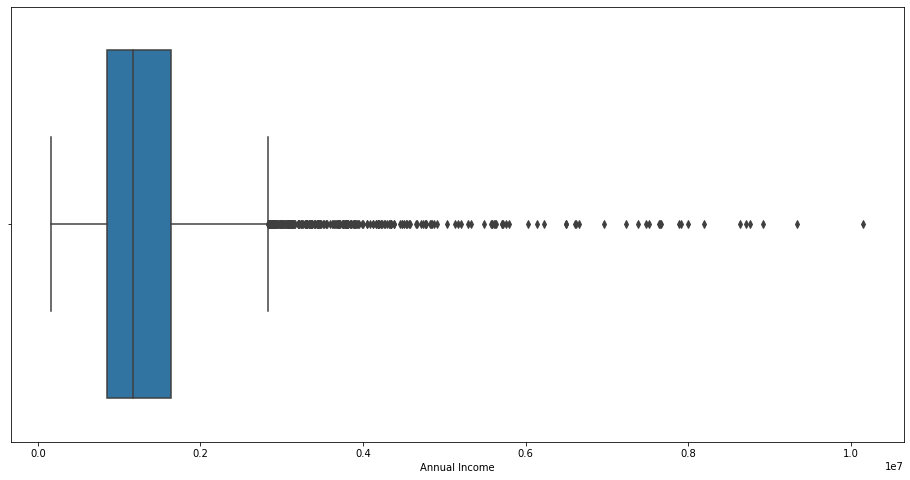

In [138]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='Annual Income', data=df)
plt.show()

In [139]:
Annual_Income_max = df['Annual Income'].quantile(0.975)
Annual_Income_max

3444213.5

In [140]:
df.loc[df['Annual Income'] > Annual_Income_max, 'Annual Income'] = df['Annual Income'].median()

### Current Credit Balance

In [141]:
df['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

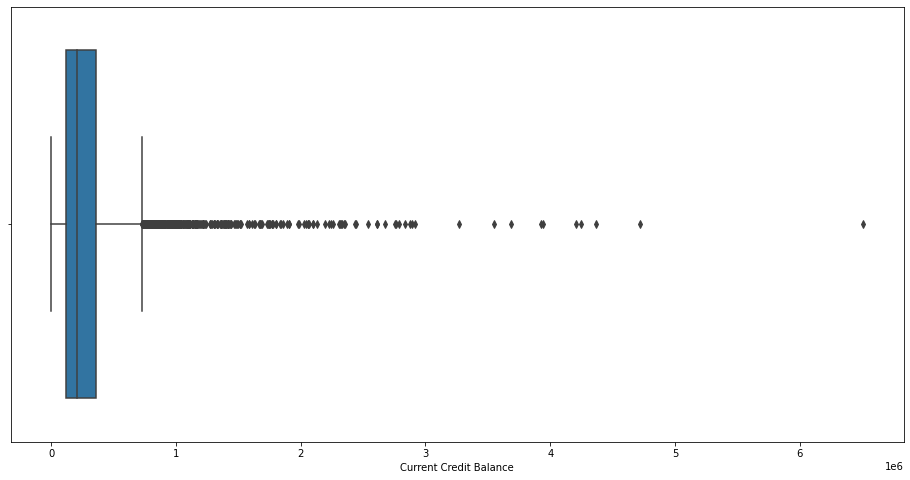

In [142]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='Current Credit Balance', data=df)
plt.show()

In [143]:
Current_Credit_Balance_max = df['Current Credit Balance'].quantile(0.975)
Current_Credit_Balance_max

1001579.7749999975

In [144]:
df.loc[(df['Current Credit Balance'] > Current_Credit_Balance_max), 'Current Credit Balance'] = df['Current Credit Balance'].median()

### Number of Open Accounts

In [145]:
df['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130934
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

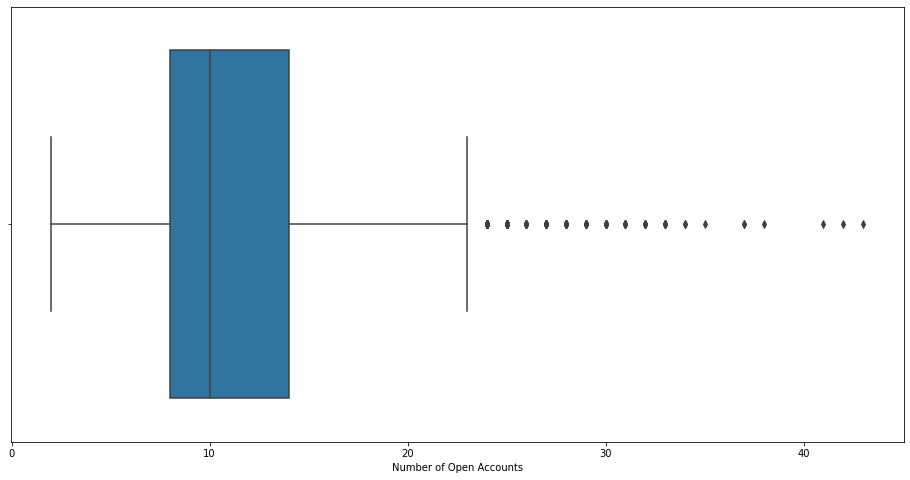

In [146]:
plt.figure(figsize=(16, 8))
sns.boxplot(x='Number of Open Accounts', data=df)
plt.show()

In [147]:
df.loc[df['Number of Open Accounts'] > 25, 'Number of Open Accounts'].value_counts()

28.0    14
27.0    14
26.0    12
30.0    11
29.0    10
32.0     6
33.0     6
31.0     6
34.0     2
37.0     2
43.0     1
41.0     1
38.0     1
35.0     1
42.0     1
Name: Number of Open Accounts, dtype: int64

In [148]:
df.loc[df['Number of Open Accounts'] > 25, 'Number of Open Accounts'] = df['Number of Open Accounts'].median()

### Current Loan Amount

In [149]:
df['Current Loan Amount'].describe()

count         7500.0
mean      11873178.0
std       31926124.0
min          11242.0
25%         180169.0
50%         309573.0
75%         519882.0
max      100000000.0
Name: Current Loan Amount, dtype: float64

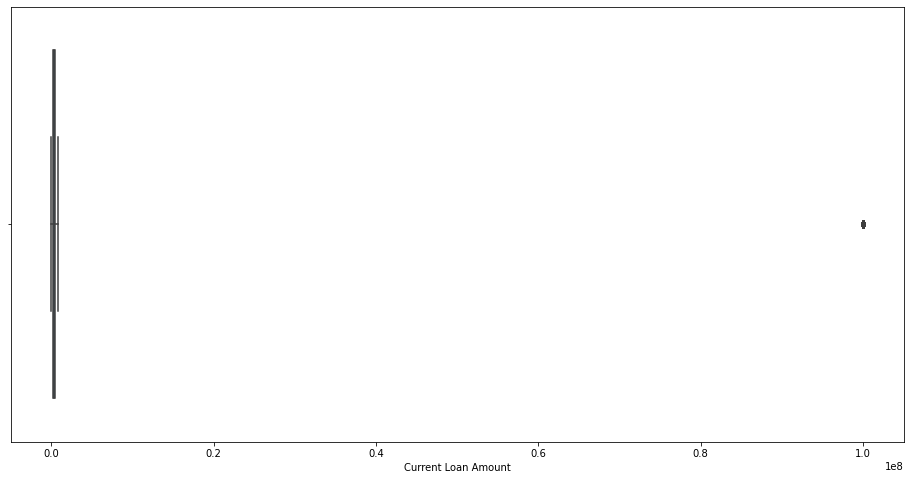

In [150]:
plt.figure(figsize=(16, 8))
sns.boxplot(df['Current Loan Amount'])
plt.show()

In [151]:
df.loc[df['Current Loan Amount'] > 700000, 'Current Loan Amount'] = df['Current Loan Amount'].median()

### Monthly Debt

In [152]:
df['Monthly Debt'].describe()

count      7500.000000
mean      18314.453125
std       11926.764648
min           0.000000
25%       10067.500000
50%       16076.500000
75%       23818.000000
max      136679.000000
Name: Monthly Debt, dtype: float64

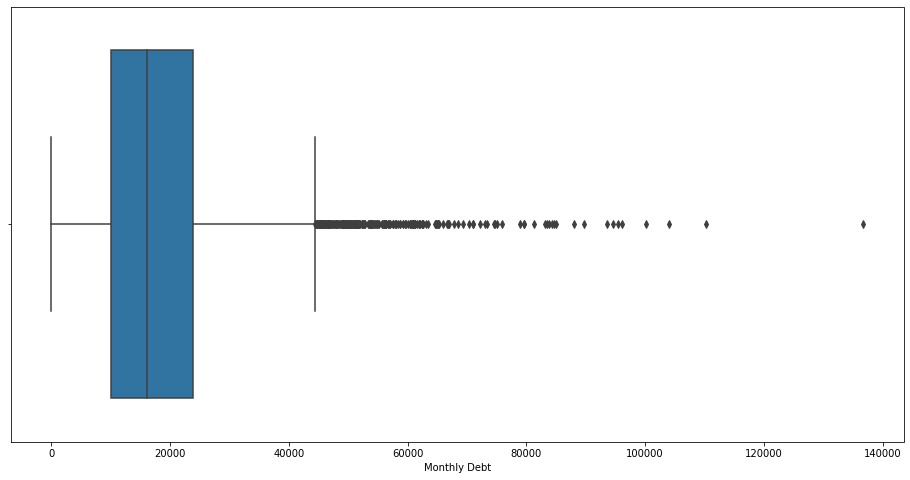

In [153]:
plt.figure(figsize=(16, 8))
sns.boxplot(df['Monthly Debt'])
plt.show()

In [154]:
df['Monthly Debt'].quantile(.975)

47950.149999999965

In [155]:
df.loc[df['Monthly Debt'] > 47950, 'Monthly Debt'] = df['Monthly Debt'].median()

In [156]:
df.loc[df['Monthly Debt'] < 4000, ['Credit Default']].value_counts()

Credit Default
0                 337
1                  98
dtype: int64

### Tax Liens

In [157]:
df['Tax Liens'].describe()

count    7500.000000
mean        0.030133
std         0.271604
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Tax Liens, dtype: float64

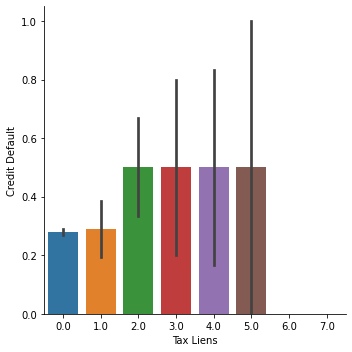

In [158]:
sns.catplot(x='Tax Liens',
            y='Credit Default',
            kind='bar',
            data=df);

### Years of Credit History

In [159]:
df['Years of Credit History'].describe()

count    7500.000000
mean       18.317467
std         7.041946
min         4.000000
25%        13.500000
50%        17.000000
75%        21.799999
max        57.700001
Name: Years of Credit History, dtype: float64

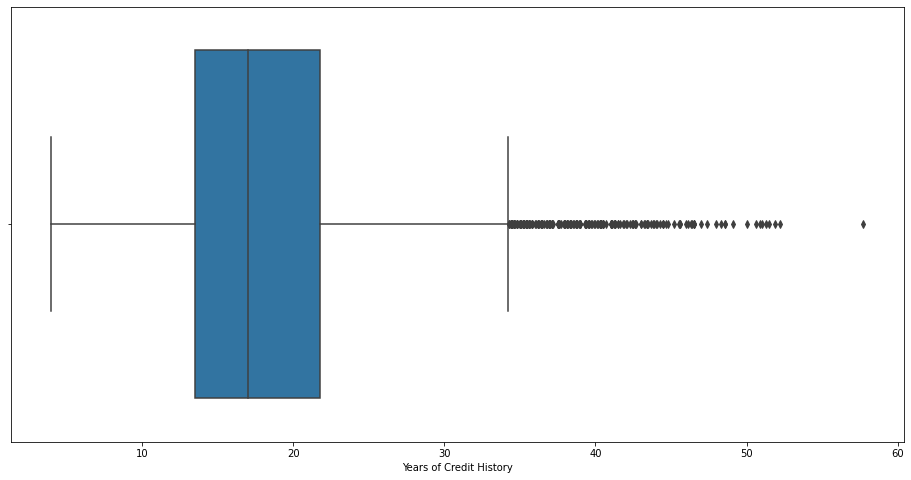

In [160]:
plt.figure(figsize=(16, 8))
sns.boxplot(df['Years of Credit History'])
plt.show()

In [161]:
df.loc[df['Years of Credit History'] > 35, 'Years of Credit History'] = df['Years of Credit History'].median()

### Maximum Open Credit

In [162]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451538e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

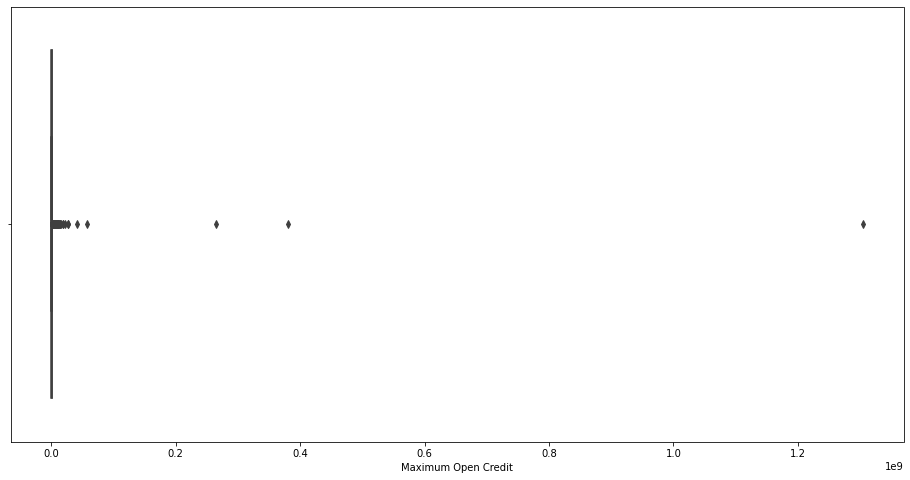

In [163]:
plt.figure(figsize=(16, 8))
sns.boxplot(df['Maximum Open Credit'])
plt.show()

In [164]:
df.loc[(df['Maximum Open Credit'] > 1400000), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()

### Months since last delinquent

In [165]:
df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688807
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

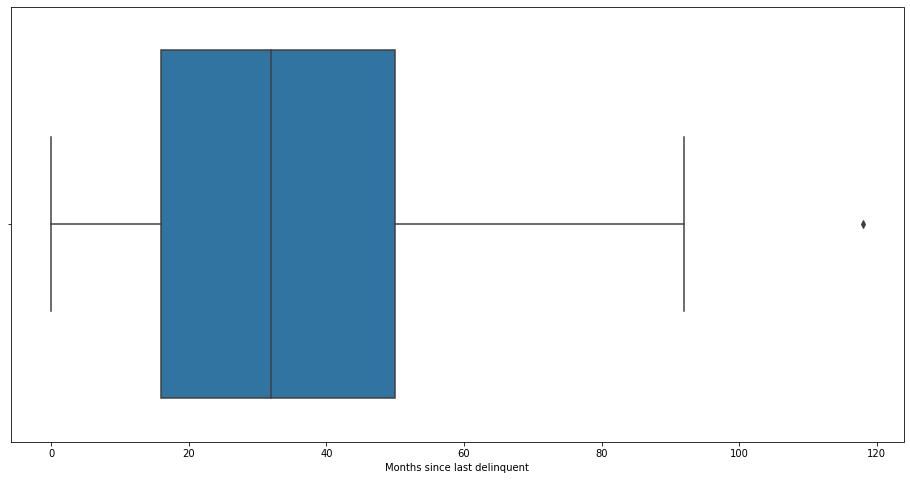

In [166]:
plt.figure(figsize=(16, 8))
sns.boxplot(df['Months since last delinquent'])
plt.show()

In [167]:
df.loc[df['Months since last delinquent'] > 95, 'Months since last delinquent'] = df['Months since last delinquent'].median()

### Bankruptcies

In [168]:
df['Bankruptcies'].describe()

count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

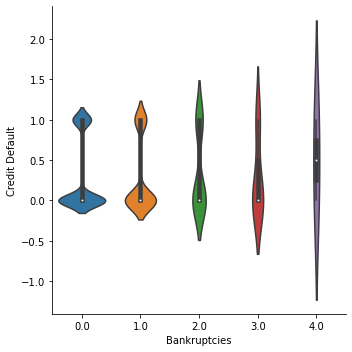

In [169]:
sns.catplot(x='Bankruptcies',
            y='Credit Default',
            kind='violin',
            data=df);

In [170]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

### Credit Score

In [171]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087524
std      1604.451416
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

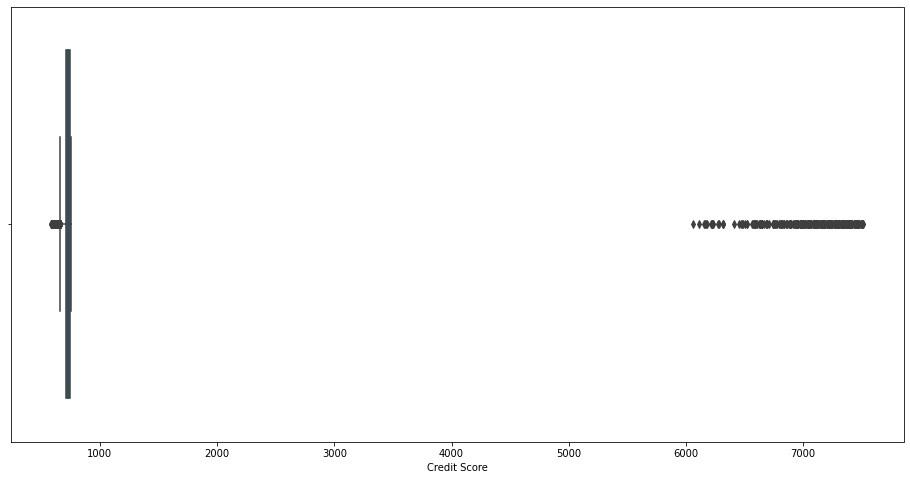

In [172]:
plt.figure(figsize=(16, 8))
sns.boxplot(df['Credit Score'])
plt.show()

In [173]:
df.loc[(df['Credit Score'] > 700), 'Credit Default'].value_counts()

0    3691
1    1218
Name: Credit Default, dtype: int64

In [174]:
df.loc[(df['Credit Score'] > 751) | (df['Credit Score'] < 680), 'Credit Score'] = df['Credit Score'].median()

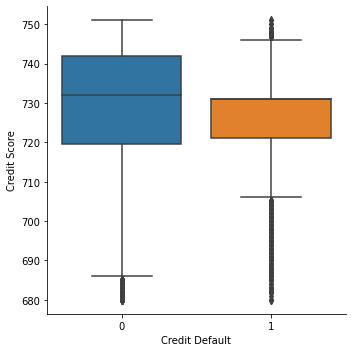

In [175]:
sns.catplot(y='Credit Score',
            x='Credit Default',
            kind='box',
            data=df);

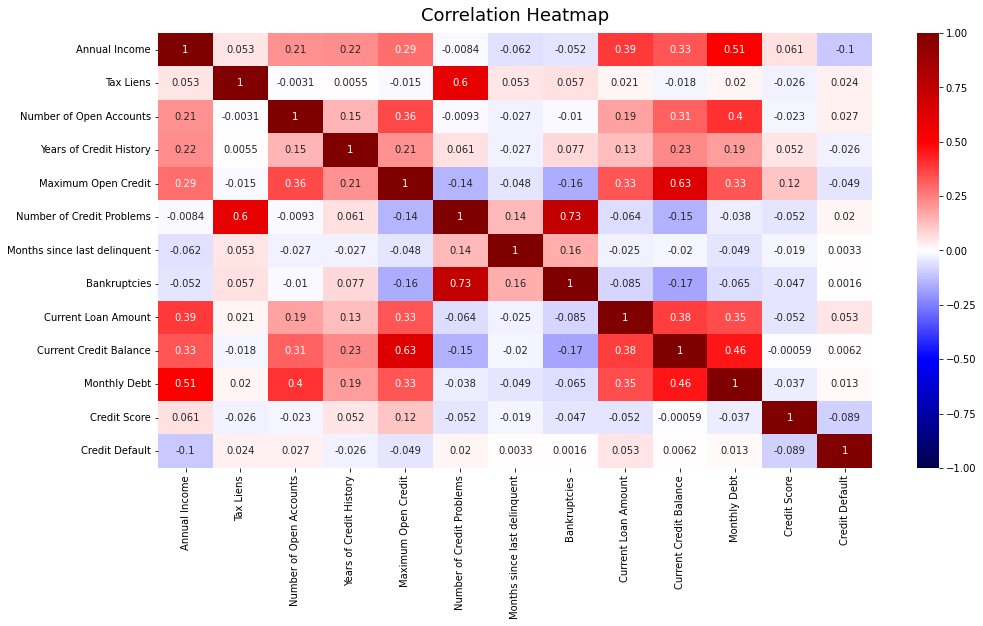

In [180]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='seismic')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);